In [1]:
import cv2  # OpenCVライブラリ
import matplotlib.pyplot as plt 
import numpy as np
import torch

%matplotlib inline

In [2]:
from utils.ssd_model import SSD

voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']

# SSD300の設定
ssd_cfg = {
    'num_classes': 21,  # 背景クラスを含めた合計クラス数
    'input_size': 300,  # 画像の入力サイズ
    'bbox_aspect_num': [4, 6, 6, 6, 4, 4],      # 出力するDBoxのアスペクト比の種類
    'feature_maps': [38, 19, 10, 5, 3, 1],      # 各sourceの画像サイズ
    'steps': [8, 16, 32, 64, 100, 300],         # DBoxの大きさを決める
    'min_sizes': [30, 60, 111, 162, 213, 264],  # DBoxの大きさを決める
    'max_sizes': [60, 111, 162, 213, 264, 315], # DBoxの大きさを決める
    'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2],],
}

# SSDネットワークモデル
net = SSD(phase='inference', cfg=ssd_cfg)

# SSDの学習済みの重みを設定
net_weights = torch.load('./weights/ssd300_50.pth', map_location={'cuda:0': 'cpu'})

# net_weights = torch.load('./weights/ssd300_mAP_77.44_v2.pth', map_location={'cuda:0': 'cpu'})

net.load_state_dict(net_weights)

print('ネットワーク設定完了：学習済みの重みをロードしました')

ネットワーク設定完了：学習済みの重みをロードしました


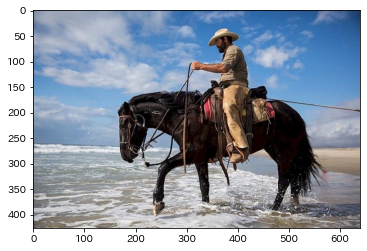

torch.Size([1, 21, 200, 5])
tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0236, 0.0117, 0.8350, 0.1501, 0.9723],
          [0.0122, 0.8136, 0.3538, 0.8614, 0.4138],
          [0.0120, 0.4310, 0.2309, 0.5104, 0.3978],
          ...,
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0665, 0.7309, 0.7870, 0.8519, 0.9446],
          [0.0503, 0.2562, 0.3256, 0.8592, 0.9027],
          [0.0247, 0.2333, 0.4079, 0.3537, 0.7423],
          ...,
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.00

In [3]:
from utils.ssd_model import DataTransform

# 1. 画像読み込み
image_file_path = './data/cowboy-757575_640.jpg'
img = cv2.imread(image_file_path)  # [高さ][幅][色BGR]
height, width, channels = img.shape   # 画像のサイズを取得

# 2. 元画像の表示
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# 3. 前処理クラスの作成
color_mean = (104, 117, 123)
input_size = 300
transform = DataTransform(input_size, color_mean)

# 4. 前処理
phase = 'val'
img_transformed, boxes, labels = transform(img, phase, '', '')   # アノテーションはないので、''にする
img = torch.from_numpy(img_transformed[:, :, (2, 1, 0)]).permute(2, 0, 1)

# 5. SSDで予測
net.eval()   # ネットワークを訓練モードへ
x = img.unsqueeze(0)  # ミニバッチ化:torch.size([1, 3, 300, 300])
detections = net(x)

print(detections.shape)
print(detections)

# output: torch.Size([batch_num, 21, 200, 5]) = (batch_num, クラス, confのtop200, 規格化されたBBoxの情報)
# 規格化されたBBoxの情報 (確信度, xmin, ymin, xmax, ymax)

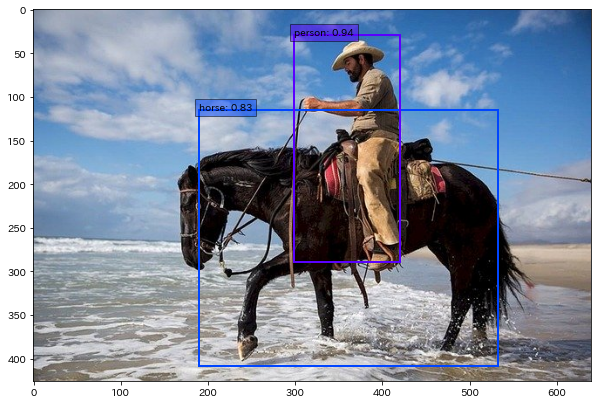

In [9]:
# 画像に対する予測
from utils.ssd_predict_show import SSDPredictShow

# ファイルパス
image_file_path = "./data/cowboy-757575_640.jpg"

# 予測と、予測結果を画像で描画する
ssd = SSDPredictShow(eval_categories=voc_classes, net=net)
ssd.show(image_file_path, data_confidence_level=0.5)